In [1]:
# Imports & Global Settings 

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
from sklearn.base import clone, is_classifier
from sklearn.inspection import permutation_importance


In [2]:
# Global Plot Settings

avenir_font = FontProperties(family='Avenir')
avenir_font_small = FontProperties(family='Avenir', size=6)

# Apply Avenir globally for matplotlib
plt.rcParams.update({
    'font.family': 'Avenir',
    'font.size': 10,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 200
})

# target_colors = {
#     'vitamin_d': '#1f77b4',        # blue
#     'hdl_cholesterol': '#ff7f0e',  # orange
#     'a1c': '#2ca02c'               # green
# }

target_colors = {
    'triglycerides': '#1f77b4',        # blue
    'hdl_cholesterol': '#ff7f0e'  # orange
}

In [3]:
# Load cleaned data & metadata

df = pd.read_feather("../data/processed/cleaned_nhanes.feather")
with open("../data/processed/metadata.json") as f:
    meta = json.load(f)

cat_features = meta["cat_features"]
num_features = meta["num_features"]
target_cols = meta["target_cols"]

assert df[target_cols].notnull().all().all(), "\u274c Unexpected NaNs in target columns!"

In [4]:
# Reload baseline models 

rf_model = joblib.load("../models/baseline_rf_model.pkl")
linear_model = joblib.load("../models/baseline_linear_model.pkl")

In [5]:
# Load testing and training data from 02 (note: y targets are scaled already. X are not bc they get scaled through the pipeline).

X_train = pd.read_feather("../data/processed/X_train.feather")
X_test = pd.read_feather("../data/processed/X_test.feather")
y_train = pd.read_feather("../data/processed/y_train_scaled.feather")
y_test = pd.read_feather("../data/processed/y_test_scaled.feather")

target_scaler = joblib.load("../models/target_scaler.pkl")

In [6]:
# Preprocessing Pipeline 

# Numeric pipeline 
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline 
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine in column transformer 
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

In [7]:
# Baseline models (already fit)
baseline_models = {
    "Baseline: Random Forest": rf_model,
    "Baseline: Linear Regression": linear_model
}

# Tunable models
auxiliary_models = {
    "Random Forest": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
    ]),
    "KNN": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(KNeighborsRegressor()))
    ]),
    "Ridge Regression": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(Ridge()))
    ]),
    "SVR": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(SVR()))
    ])
}

In [8]:
# some params for the grid search

# set n_splits for the CV #
cv = KFold(n_splits=12, shuffle=True, random_state=42)

# local hardware params
n_cpus = 4
#n_cpus = -1 # this is use all available cpus

# for RandomizedSearchCV to assign number of random samples
grid_samp = 100

In [9]:
# Random Forest Regressor Hyperparameter Tuning

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# LONG
param_grid_rf = {
    'regressor__estimator__n_estimators': [100, 300, 500, 800, 1000],
    'regressor__estimator__max_depth': [None, 10, 20, 30, 50],
    'regressor__estimator__min_samples_split': [2, 4, 6, 8, 10],
    'regressor__estimator__max_features': ['sqrt', 'log2', None]
}
# SHORT (for testing)
# param_grid_rf = {
#     'regressor__estimator__n_estimators': [100, 300],
#     'regressor__estimator__max_depth': [None, 10, 30]
# }

# FULL GRID SEARCH
# grid_rf = GridSearchCV(
#     rf_pipeline, param_grid_rf, cv=cv, scoring='r2', n_jobs=n_cpus, verbose=1
# )

grid_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=grid_samp,               
    cv=cv,                 
    scoring='r2',
    n_jobs=n_cpus,
    verbose=1,
    random_state=42
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_rf_hp = grid_rf.best_params_

Fitting 12 folds for each of 100 candidates, totalling 1200 fits


/Users/andrewhollyday/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [10]:
# Gradient Boosting Regressor Hyperparameter Tuning

gbr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
])

# LONG
param_grid_gbr = {
    'regressor__estimator__n_estimators': [100, 300, 500, 800],
    'regressor__estimator__learning_rate': [0.01, 0.05, 0.1],
    'regressor__estimator__max_depth': [3, 5, 7],
    'regressor__estimator__subsample': [0.8, 1.0]
}
# SHORT (for testing)
# param_grid_gbr = {
#     'regressor__estimator__n_estimators': [100, 800],
#     'regressor__estimator__learning_rate': [0.01, 0.1],
# }

# FULL GRID SEARCH
# grid_gbr = GridSearchCV(
#     gbr_pipeline, param_grid_gbr, cv=cv, scoring='r2', n_jobs=n_cpus, verbose=1
# )

grid_gbr = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid_gbr,
    n_iter=grid_samp,           
    cv=cv,                 
    scoring='r2',
    n_jobs=n_cpus,
    verbose=1,
    random_state=42
)

grid_gbr.fit(X_train, y_train)
best_gbr = grid_gbr.best_estimator_
best_gbr_hp = grid_gbr.best_params_

/Users/andrewhollyday/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 12 folds for each of 72 candidates, totalling 864 fits


In [11]:
# K-Nearest Neighbors Regressor Hyperparameter Tuning

knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(KNeighborsRegressor()))
])

# LONG
param_grid_knn = {
    'regressor__estimator__n_neighbors': [3, 5, 7, 9, 11, 15],
    'regressor__estimator__weights': ['uniform', 'distance'],
    'regressor__estimator__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}
# SHORT (for testing)
# param_grid_knn = {
#     'regressor__estimator__n_neighbors': [3, 5, 9,],
#     'regressor__estimator__weights': ['uniform', 'distance'],
#     'regressor__estimator__p': [1]  # 1: Manhattan, 2: Euclidean
# }

# FULL GRID SEARCH
# grid_knn = GridSearchCV(
#     knn_pipeline, param_grid_knn, cv=cv, scoring='r2', n_jobs=n_cpus, verbose=1
# )

# Random selection from the grid to address runtime constraints
grid_knn = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_grid_knn,
    n_iter=grid_samp,              
    cv=cv,               
    scoring='r2',
    n_jobs=n_cpus,
    verbose=1,
    random_state=42
)

grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
best_knn_hp = grid_knn.best_params_

/Users/andrewhollyday/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 12 folds for each of 24 candidates, totalling 288 fits


In [12]:
# Support Vector Regressor Hyperparameter Tuning

svr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(SVR()))
])

# LONG
param_grid_svr = {
    'regressor__estimator__C': [0.1, 1.0, 10.0, 100.0],
    'regressor__estimator__epsilon': [0.01, 0.1, 0.5],
    'regressor__estimator__kernel': ['rbf', 'linear', 'poly']
}
# SHORT (for testing)
# param_grid_svr = {
#     'regressor__estimator__C': [1.0, 10.0],
#     'regressor__estimator__epsilon': [0.01, 0.5],
#     'regressor__estimator__kernel': ['rbf', 'linear',]
# }

# FULL GRID SEARCH
# grid_svr = GridSearchCV(
#     svr_pipeline, param_grid_svr, cv=cv, scoring='r2', n_jobs=n_cpus, verbose=1
# )

grid_svr = RandomizedSearchCV(
    svr_pipeline,
    param_distributions=param_grid_svr,
    n_iter=grid_samp,               
    cv=cv,                   
    scoring='r2',
    n_jobs=n_cpus,
    verbose=1,
    random_state=42
)

grid_svr.fit(X_train, y_train)
best_svr = grid_svr.best_estimator_
best_svr_hp = grid_svr.best_params_

/Users/andrewhollyday/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 12 folds for each of 36 candidates, totalling 432 fits


In [13]:
# Ridge Regression Hyperparameter Tuning

ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(Ridge()))
])

# LONG
param_grid_ridge = {
    'regressor__estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  
}
# SHORT (for testing)
# param_grid_ridge = {
#     'regressor__estimator__alpha': [0.1, 1.0, 10.0]  
# }

# FULL GRID SEARCH
# grid_ridge = GridSearchCV(
#     ridge_pipeline, param_grid_ridge, 
#     cv=cv, scoring='r2', n_jobs=n_cpus, verbose=1
# )

grid_ridge = RandomizedSearchCV(
    ridge_pipeline,
    param_distributions=param_grid_ridge,
    n_iter=grid_samp,               
    cv=cv,                   
    scoring='r2',
    n_jobs=n_cpus,
    verbose=1,
    random_state=42
)

grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
best_ridge_hp = grid_ridge.best_params_

/Users/andrewhollyday/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 12 folds for each of 5 candidates, totalling 60 fits


In [14]:
# === Evaluate auxiliary models (default hyperparameters/ no grid search) ===

auxiliary_results = []
auxiliary_residuals = []

for name, model in auxiliary_models.items():
    display_name = f"Default: {name}"  # Rename model to reflect stage

    print(f"\n🧠 Training {display_name}...")
    model.fit(X_train, y_train)  # <== IMPORTANT: use scaled target

    y_pred_scaled = model.predict(X_test)  # predictions in scaled-log space

    for i, col in enumerate(target_cols):
        # === Invert scaling
        y_pred_logged = target_scaler.inverse_transform(y_pred_scaled)[:, i]
        y_true_logged = target_scaler.inverse_transform(y_test)[:, i]

        # === Invert log transform
        y_pred_original = np.exp(y_pred_logged)
        y_true_original = np.exp(y_true_logged)

        # === Metrics in original space
        # r2 = r2_score(y_true_original, y_pred_original)
        # rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)
        r2 = r2_score(y_true_logged, y_pred_logged)
        rmse = mean_squared_error(y_true_logged, y_pred_logged, squared=False)
        
        auxiliary_results.append({
            "Model": display_name,
            "Target": col,
            "R²": r2,
            "RMSE": rmse
        })

        # === Residuals in original space
        auxiliary_residuals.append(pd.DataFrame({
            "Model": display_name,
            "Target": col,
            "True": y_true_original,
            "Predicted": y_pred_original,
            "Residual": y_true_original - y_pred_original
        }))

# Format results
auxiliary_df = pd.DataFrame(auxiliary_results)
auxiliary_residuals_df = pd.concat(auxiliary_residuals, ignore_index=True)



🧠 Training Default: Random Forest...

🧠 Training Default: Gradient Boosting...

🧠 Training Default: KNN...

🧠 Training Default: Ridge Regression...

🧠 Training Default: SVR...


In [15]:
# === Evaluate baseline models (default hyperparameters/ no grid search) ===

baseline_models = {
    "Baseline: Random Forest": rf_model,
    "Baseline: Linear Regression": linear_model
}

baseline_results = []
baseline_residuals = []

for name, model in baseline_models.items():
    y_pred_scaled = model.predict(X_test)  # predictions in scaled-log space

    for i, col in enumerate(target_cols):
        # Invert scaling
        y_pred_logged = target_scaler.inverse_transform(y_pred_scaled)[:, i]
        y_true_logged = target_scaler.inverse_transform(y_test)[:, i]

        # Invert log transform
        y_pred_original = np.exp(y_pred_logged)
        y_true_original = np.exp(y_true_logged)

        # Set for residuals
        pred_vals = y_pred_original
        true_vals = y_true_original

        # Metrics
        # r2 = r2_score(true_vals, pred_vals)
        # rmse = mean_squared_error(true_vals, pred_vals, squared=False)
        r2 = r2_score(y_true_logged, y_pred_logged)
        rmse = mean_squared_error(y_true_logged, y_pred_logged, squared=False)
        
        baseline_results.append({
            "Model": name,
            "Target": col,
            "R²": r2,
            "RMSE": rmse
        })

        # Residuals
        baseline_residuals.append(pd.DataFrame({
            "Model": name,
            "Target": col,
            "True": true_vals,
            "Predicted": pred_vals,
            "Residual": true_vals - pred_vals
        }))

# Format results
baseline_df = pd.DataFrame(baseline_results)
baseline_residuals_df = pd.concat(baseline_residuals, ignore_index=True)


In [16]:
# === Evaluate tuned models (hyperparameter-tuned pipelines) ===

tuned_models = {
    "Tuned: Random Forest": best_rf,
    "Tuned: Gradient Boosting": best_gbr,
    "Tuned: KNN": best_knn,
    "Tuned: Ridge": best_ridge,
    "Tuned: SVR": best_svr
}

tuned_results = []
tuned_residuals = []

for name, model in tuned_models.items():
    y_pred_scaled = model.predict(X_test)

    for i, col in enumerate(target_cols):
        # Invert scaling
        y_pred_logged = target_scaler.inverse_transform(y_pred_scaled)[:, i]
        y_true_logged = target_scaler.inverse_transform(y_test)[:, i]

        # Invert log transform
        y_pred_original = np.exp(y_pred_logged)
        y_true_original = np.exp(y_true_logged)

        # Define these for residuals
        pred_vals = y_pred_original
        true_vals = y_true_original

        # Metrics in original space
        # r2 = r2_score(true_vals, pred_vals)
        # rmse = mean_squared_error(true_vals, pred_vals, squared=False)
        r2 = r2_score(y_true_logged, y_pred_logged)
        rmse = mean_squared_error(y_true_logged, y_pred_logged, squared=False)

        tuned_results.append({
            "Model": name,
            "Target": col,
            "R²": r2,
            "RMSE": rmse
        })

        # Residuals in original space
        tuned_residuals.append(pd.DataFrame({
            "Model": name,
            "Target": col,
            "True": true_vals,
            "Predicted": pred_vals,
            "Residual": true_vals - pred_vals
        }))

# Format results
tuned_df = pd.DataFrame(tuned_results)
tuned_residuals_df = pd.concat(tuned_residuals, ignore_index=True)



In [17]:
# Combine metric and residual results
combined_df = pd.concat([tuned_df, baseline_df, auxiliary_df], ignore_index=True)
all_residuals_df = pd.concat([
    baseline_residuals_df,
    auxiliary_residuals_df,  
    tuned_residuals_df
], ignore_index=True)

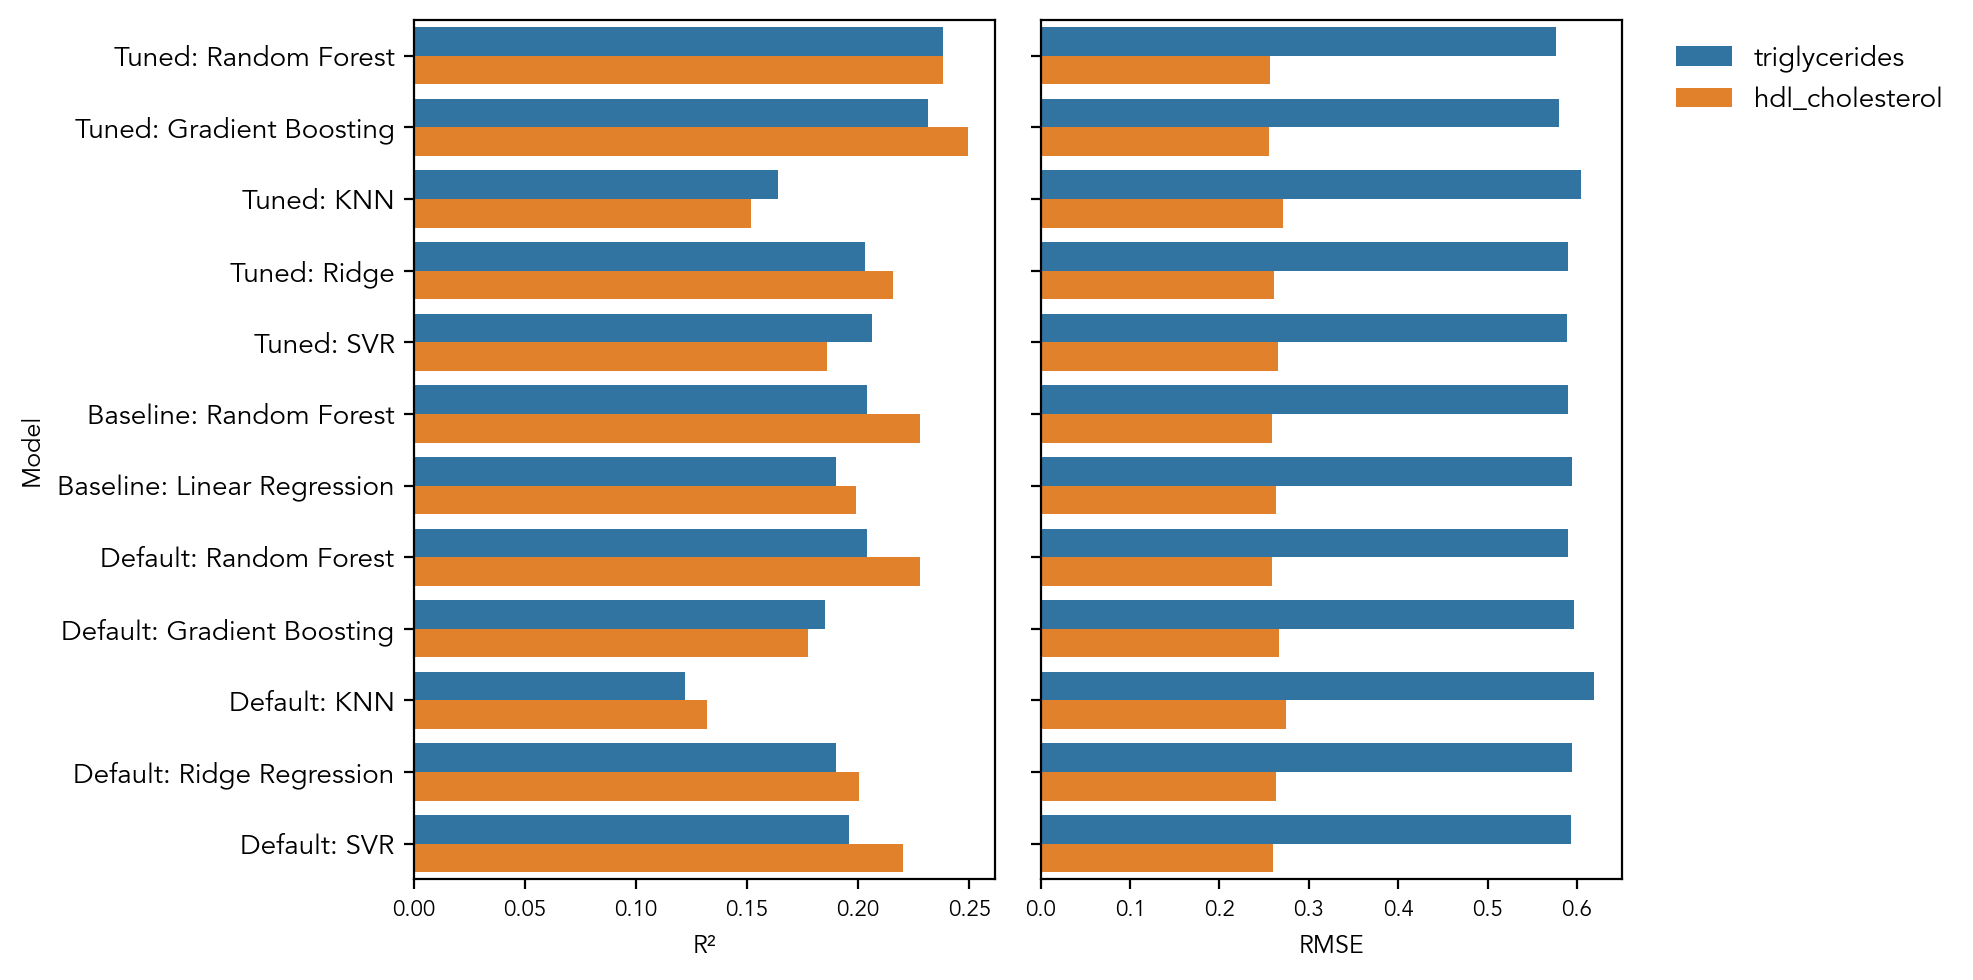

In [18]:
# === Plot baseline models and tuned model metrics

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for ax, metric in zip(axes, ["R²", "RMSE"]):
    sns.barplot(data=combined_df, x=metric, y="Model", hue="Target", ax=ax, palette=target_colors)
    ax.tick_params(axis='both', labelsize=8)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(avenir_font)
if axes[1].get_legend():
    axes[1].legend(
        title="",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
        prop=avenir_font
    )
if axes[0].get_legend():
    axes[0].get_legend().remove()

# axes[0].set_xlim(0.1, 0.25)
# axes[1].set_xlim(0.85, 1.0)

axes[1].set_ylabel("") 

plt.tight_layout()
plt.show()

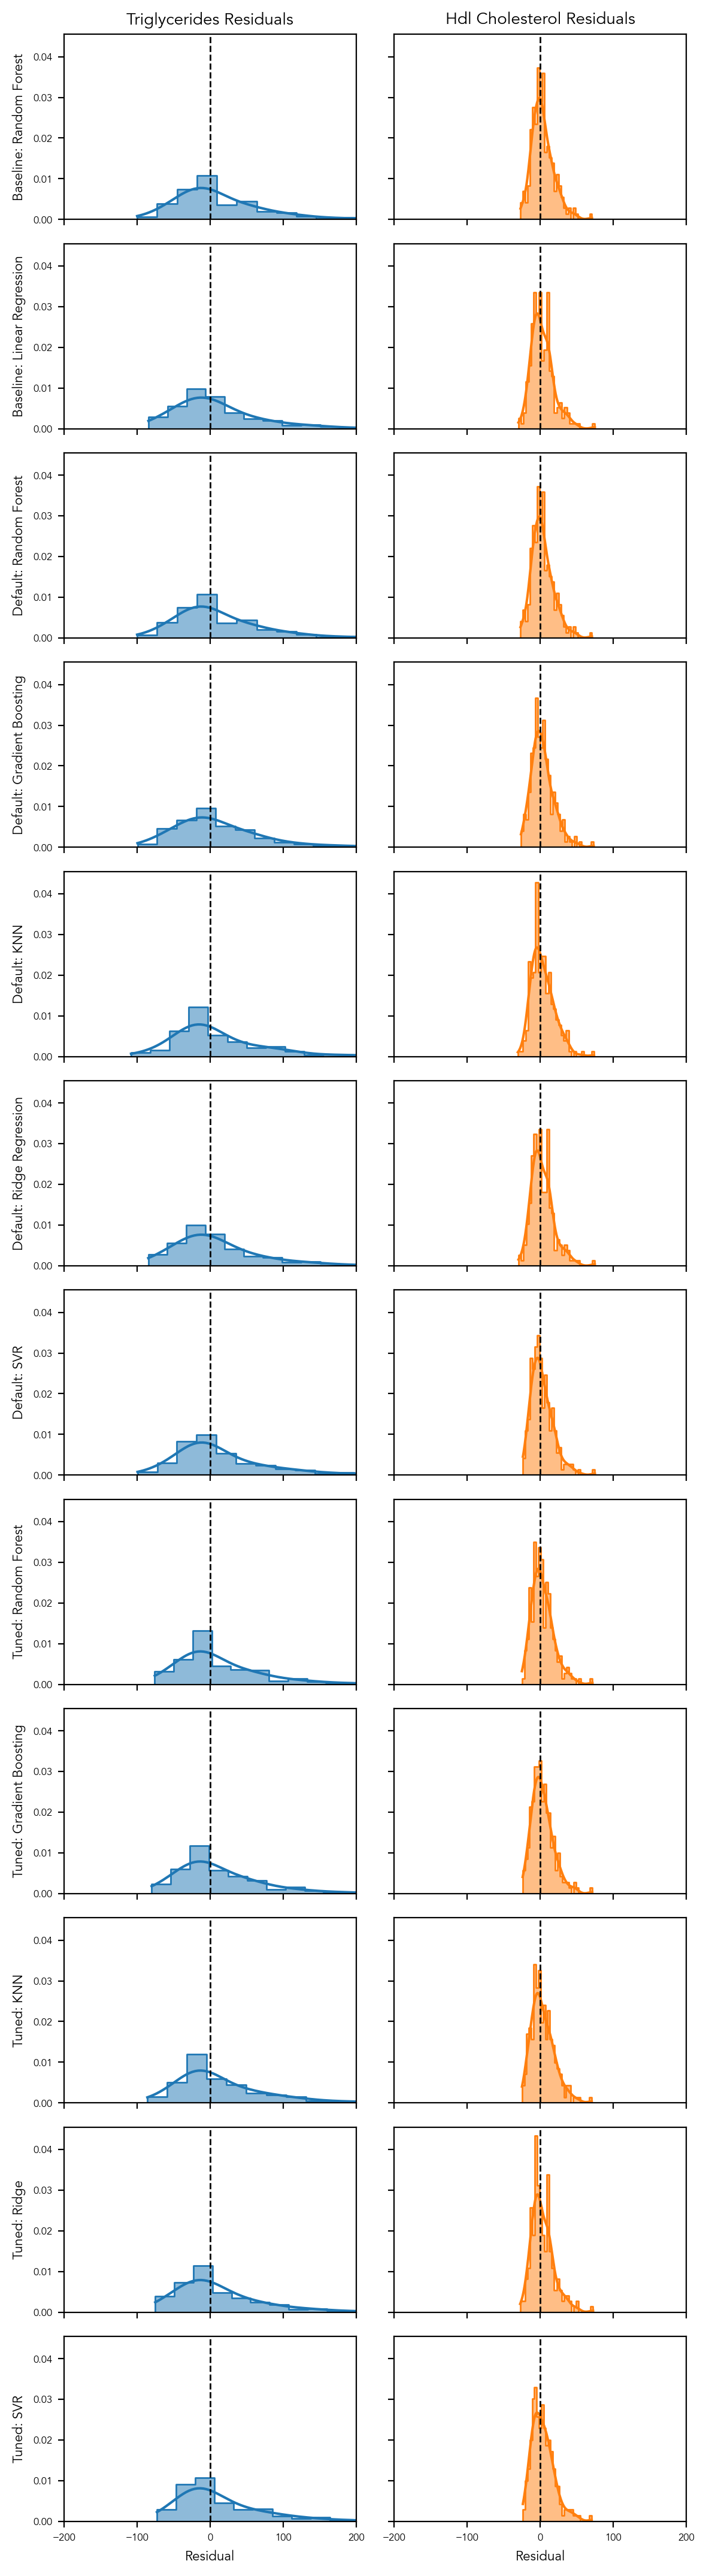

In [61]:
# Residual Plots

# Unique model and target combinations
models = all_residuals_df["Model"].unique()
targets = target_cols

# Grid dimensions
n_rows = len(models)
n_cols = len(targets)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 1.8 * n_rows), sharex=True, sharey=True)

for i, model in enumerate(models):
    for j, target in enumerate(targets):
        ax = axes[i, j] if n_rows > 1 else axes[j]

        # Filter data
        subset = all_residuals_df[
            (all_residuals_df["Model"] == model) & (all_residuals_df["Target"] == target)
        ]

        # Plot
        sns.histplot(
            data=subset,
            x="Residual",
            bins=30,
            kde=True,
            color=target_colors[target],
            stat="density",
            element="step",
            ax=ax
        )
        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.set_xlim(-200, 200)
        ax.grid(False)

        # Axis labels
        if j == 0:
            ax.set_ylabel(model, fontsize=8, fontproperties=avenir_font)
        else:
            ax.set_ylabel("", fontproperties=avenir_font)

        if i == n_rows - 1:
            ax.set_xlabel("Residual", fontsize=8, fontproperties=avenir_font)
        else:
            ax.set_xlabel("", fontproperties=avenir_font)

        # Column titles (top row only)
        if i == 0:
            title_text = f"{target.replace('_', ' ').title()} Residuals"
            ax.set_title(title_text, fontsize=10, fontproperties=avenir_font)

        # Tick font styling
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(avenir_font_small)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


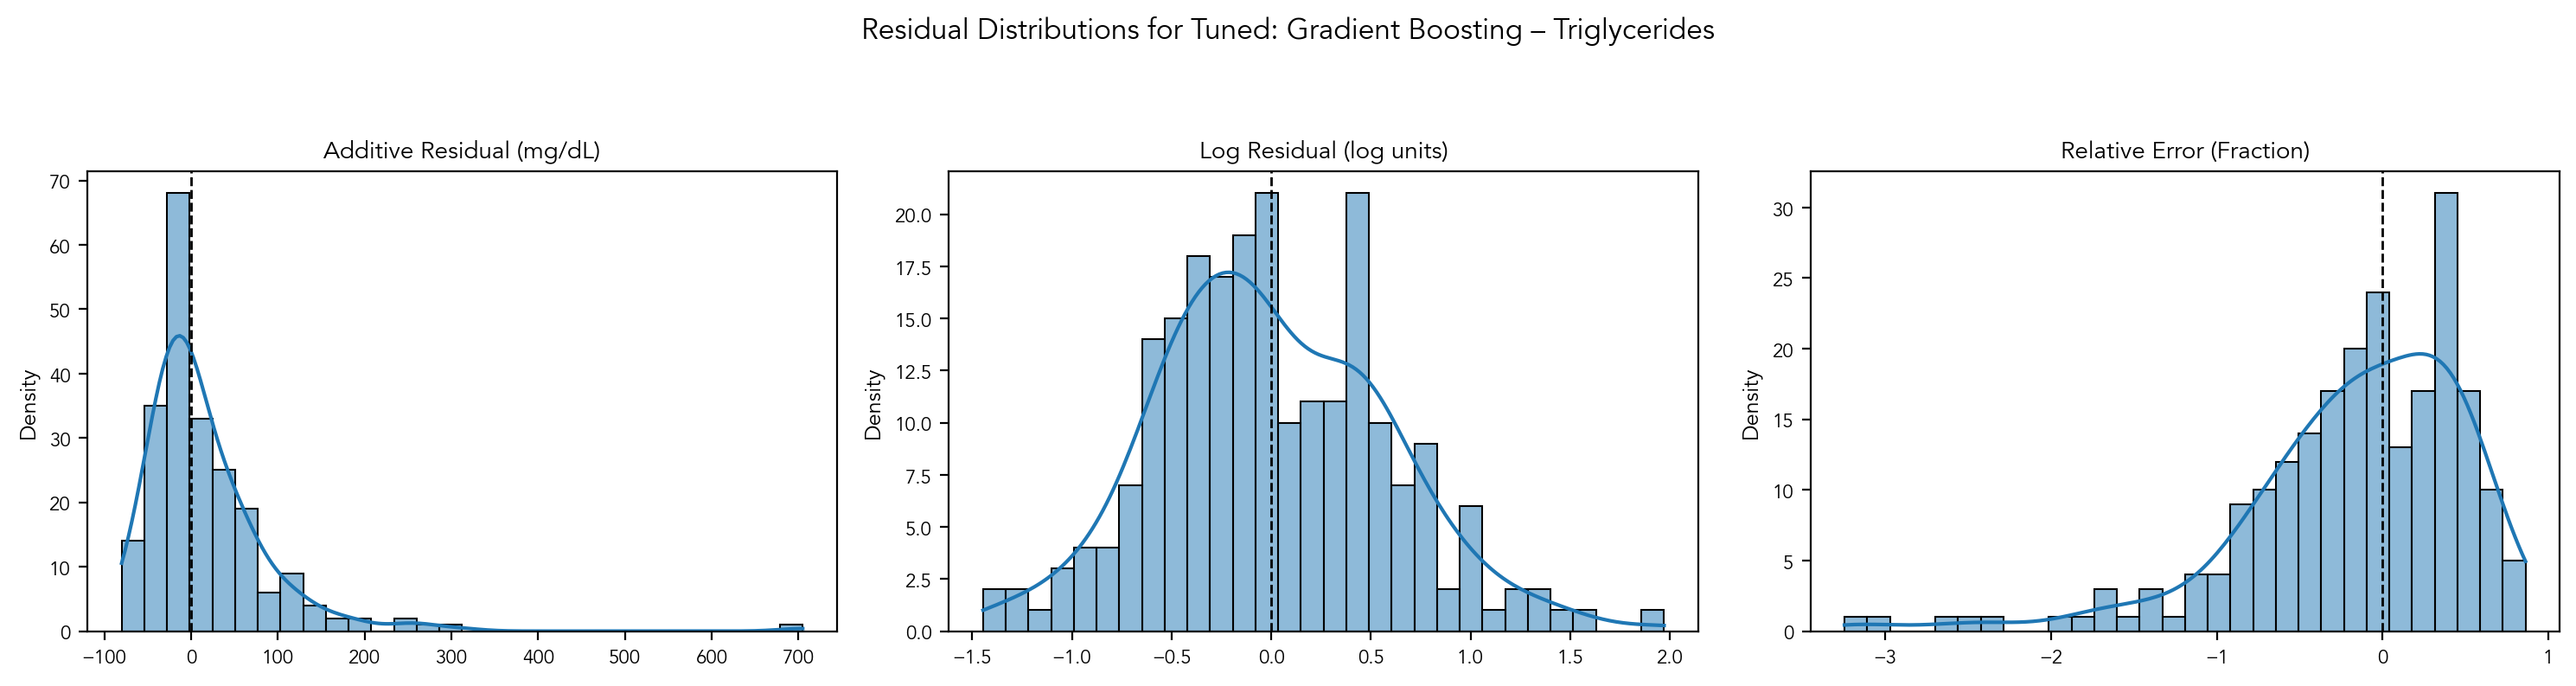

In [65]:
display_name_map = {
    "triglycerides": "Triglycerides",
    "hdl_cholesterol": "HDL Cholesterol"
}

# Choose one model to illustrate (e.g., best tuned model)
model_name = "Tuned: Gradient Boosting"
target = "triglycerides"  # or "hdl_cholesterol"

# Filter for selected model + target
df = all_residuals_df[
    (all_residuals_df["Model"] == model_name) &
    (all_residuals_df["Target"] == target)
].copy()

# === Reconstruct log-space values
# Assumes original residuals were computed as:
# np.exp(y_true_logged) - np.exp(y_pred_logged)
# So reverse to get y_pred_logged
df["Pred_Log"] = np.log(df["Predicted"])
df["True_Log"] = np.log(df["True"])

# === Compute residual types
df["Residual_Original"] = df["True"] - df["Predicted"]
df["Residual_Log"] = df["True_Log"] - df["Pred_Log"]
df["Residual_Relative"] = (df["True"] - df["Predicted"]) / df["True"]

# === Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

residual_types = [
    ("Residual_Original", "Additive Residual (mg/dL)"),
    ("Residual_Log", "Log Residual (log units)"),
    ("Residual_Relative", "Relative Error (Fraction)")
]

for ax, (col, title) in zip(axes, residual_types):
    sns.histplot(df[col], kde=True, bins=30, ax=ax, color=target_colors[target])
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.grid(False)

plt.suptitle(f"Residual Distributions for {model_name} – {display_name_map.get(target, target)}", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### 📊 Residual Distribution Interpretation – Triglycerides

#### 1. **Additive Residual (mg/dL)**
- Distribution is **positively skewed**, with a long tail beyond +200 mg/dL
- Most residuals are between **–50 and +100 mg/dL**, with a peak just above zero
- Indicates the model **slightly underpredicts** triglycerides on average
- Some **large errors** (> +300 mg/dL) suggest high values are difficult to capture

#### 2. **Log Residual (log units)**
- Centered roughly around **0**, indicating no major multiplicative bias
- A log residual of **+0.69** = model underpredicts by a factor of **2×**
- Most predictions are within about **half to twice** the true value
- The spread is more **symmetrical** than the additive view

#### 3. **Relative Error (Fraction)**
- Bulk of errors between **–0.5 and +0.5**, meaning predictions are off by ±50% in many cases
- Skewed slightly negative: model is more likely to **overestimate** in relative terms for low values
- Long tail on the left shows large percentage errors for small true values

---

### 🧠 Key Takeaways
- The model struggles more with **extremely high triglyceride values**
- Log and relative views suggest **multiplicative performance is more stable** than absolute accuracy
- May benefit from:
  - Stratified modeling (e.g., low vs. high TG groups)
  - More features capturing extreme cases
  - Robust regression methods or outlier trimming


In [20]:
# compute metrics across many CVs

cv_folds = [3, 6, 12, 24, 48]

tuned_CVopt_results = []

for model_name, base_model in tuned_models.items():
    for k in cv_folds:
        print(f"=== {model_name} | CV Folds: {k} ===")
        
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        model = clone(base_model)

        # R² per target
        r2_scores = cross_val_score(
            model, X_train, y_train,
            cv=cv, scoring='r2', n_jobs=n_cpus
        )

        # RMSE per target (via negative MSE)
        neg_mse_scores = cross_val_score(
            model, X_train, y_train,
            cv=cv,
            scoring=make_scorer(mean_squared_error, greater_is_better=False),
            n_jobs=n_cpus
        )
        rmse_scores = np.sqrt(-neg_mse_scores)

        # Save average metrics for each target
        for i, col in enumerate(y_train.columns):
            tuned_CVopt_results.append({
                "Model": f"{model_name} (CV={k})",
                "Target": col,
                "CV Folds": k,
                "R²": r2_scores[i],
                "RMSE": rmse_scores[i]
            })

# Combine into a DataFrame
tuned_CVopt_df = pd.DataFrame(tuned_CVopt_results)


=== Tuned: Random Forest | CV Folds: 3 ===
=== Tuned: Random Forest | CV Folds: 6 ===
=== Tuned: Random Forest | CV Folds: 12 ===
=== Tuned: Random Forest | CV Folds: 24 ===
=== Tuned: Random Forest | CV Folds: 48 ===
=== Tuned: Gradient Boosting | CV Folds: 3 ===
=== Tuned: Gradient Boosting | CV Folds: 6 ===
=== Tuned: Gradient Boosting | CV Folds: 12 ===
=== Tuned: Gradient Boosting | CV Folds: 24 ===
=== Tuned: Gradient Boosting | CV Folds: 48 ===
=== Tuned: KNN | CV Folds: 3 ===
=== Tuned: KNN | CV Folds: 6 ===
=== Tuned: KNN | CV Folds: 12 ===
=== Tuned: KNN | CV Folds: 24 ===
=== Tuned: KNN | CV Folds: 48 ===
=== Tuned: Ridge | CV Folds: 3 ===
=== Tuned: Ridge | CV Folds: 6 ===
=== Tuned: Ridge | CV Folds: 12 ===
=== Tuned: Ridge | CV Folds: 24 ===
=== Tuned: Ridge | CV Folds: 48 ===
=== Tuned: SVR | CV Folds: 3 ===
=== Tuned: SVR | CV Folds: 6 ===
=== Tuned: SVR | CV Folds: 12 ===
=== Tuned: SVR | CV Folds: 24 ===
=== Tuned: SVR | CV Folds: 48 ===


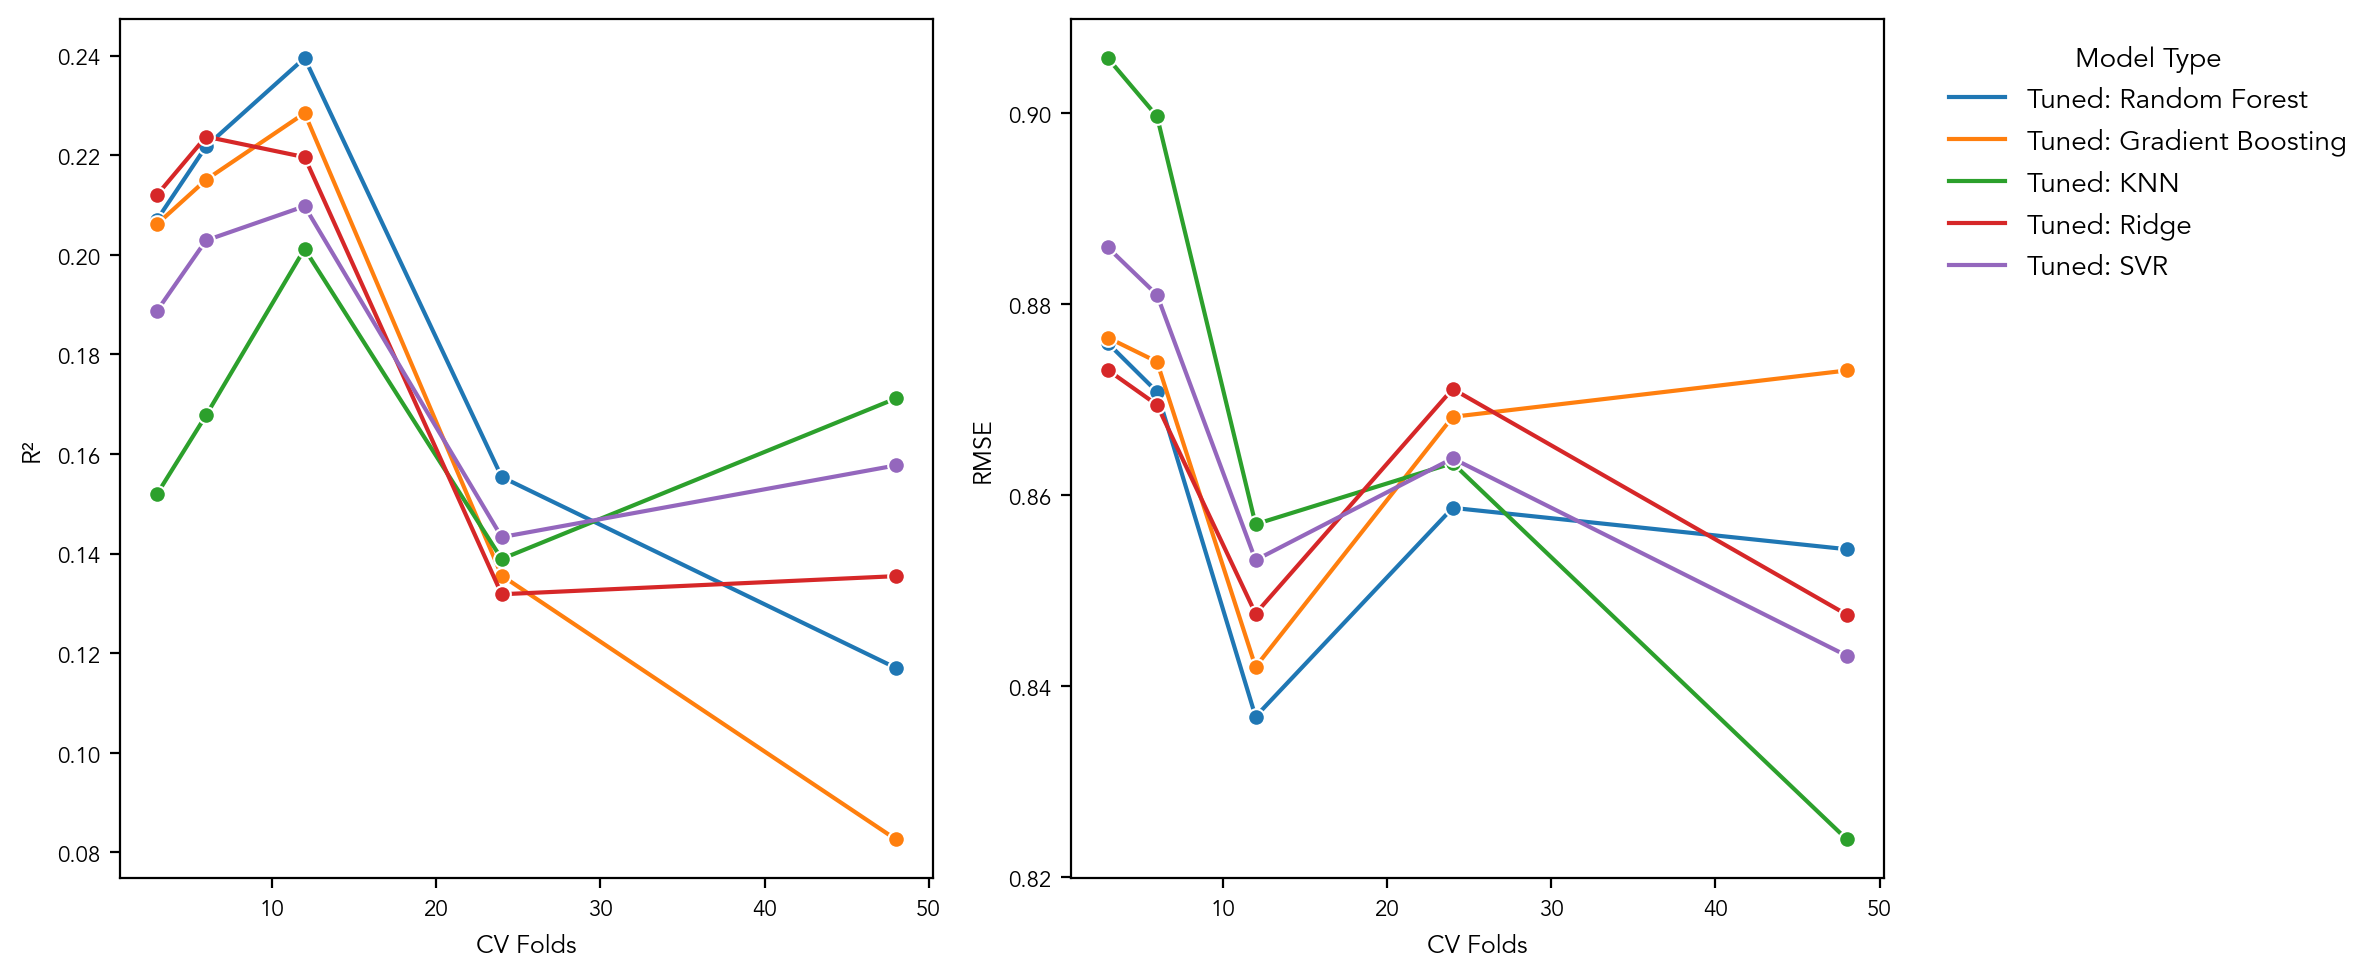

In [21]:
tuned_CVopt_df["Model Type"] = tuned_CVopt_df["Model"].str.extract(r"^(Tuned: .+?) \(CV=")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# R² Plot
sns.lineplot(
    data=tuned_CVopt_df,
    x="CV Folds", y="R²",
    hue="Model Type",
    marker="o", ax=axes[0],
    errorbar=None
)
axes[0].set_title("", fontproperties=avenir_font)
axes[0].tick_params(axis='both', labelsize=8)
axes[0].get_legend().remove()  # remove left legend

# RMSE Plot
sns.lineplot(
    data=tuned_CVopt_df,
    x="CV Folds", y="RMSE",
    hue="Model Type",
    marker="o", ax=axes[1],
    errorbar=None
)
axes[1].set_title("", fontproperties=avenir_font)
axes[1].tick_params(axis='both', labelsize=8)
axes[1].legend(
    title="Model Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
    prop=avenir_font
)

plt.tight_layout()
plt.show()


In [22]:
# Dictionary of best trained pipelines
best_models = {
    "Random Forest": best_rf,
    "Gradient Boosting": best_gbr,
    "KNN": best_knn,
    "Ridge": best_ridge,
    "SVR": best_svr
}

X_val = X_train.copy()
y_val = y_train.copy()

importances_all = []

for model_name, pipe in best_models.items():
    print(f"\n→ Extracting feature importances for {model_name}")

    # Get preprocessor and transform features
    preprocessor = pipe.named_steps["preprocessing"]
    X_transformed = preprocessor.transform(X_val)
    feature_names = preprocessor.get_feature_names_out()

    # Get regressor and unwrap estimators
    regressor = pipe.named_steps["regressor"]
    if isinstance(regressor, MultiOutputRegressor):
        estimators = regressor.estimators_
    else:
        estimators = [regressor]

    for i, col in enumerate(y_val.columns):
        print(f"   Target: {col}")
        model = estimators[i]

        # Tree-based models
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_

        # Ridge
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_)

        # Permutation-based (KNN, SVR)
        else:
            result = permutation_importance(
                model, X_transformed, y_val[col],
                n_repeats=5, random_state=42, n_jobs=n_cpus
            )
            importances = result.importances_mean

        df = pd.DataFrame({
            "Model": model_name,
            "Target": col,
            "Feature": feature_names,
            "Importance": importances.ravel()
        }).sort_values("Importance", ascending=False)

        importances_all.append(df)

# Combine all
all_importances_df = pd.concat(importances_all, ignore_index=True)



→ Extracting feature importances for Random Forest
   Target: triglycerides
   Target: hdl_cholesterol

→ Extracting feature importances for Gradient Boosting
   Target: triglycerides
   Target: hdl_cholesterol

→ Extracting feature importances for KNN
   Target: triglycerides
   Target: hdl_cholesterol

→ Extracting feature importances for Ridge
   Target: triglycerides
   Target: hdl_cholesterol

→ Extracting feature importances for SVR
   Target: triglycerides
   Target: hdl_cholesterol


In [23]:
all_importances_df["NormWithinTarget"] = (
    all_importances_df
    .groupby(["Model", "Target"])["Importance"]
    .transform(lambda x: x / x.sum() if x.sum() > 0 else 0)
)


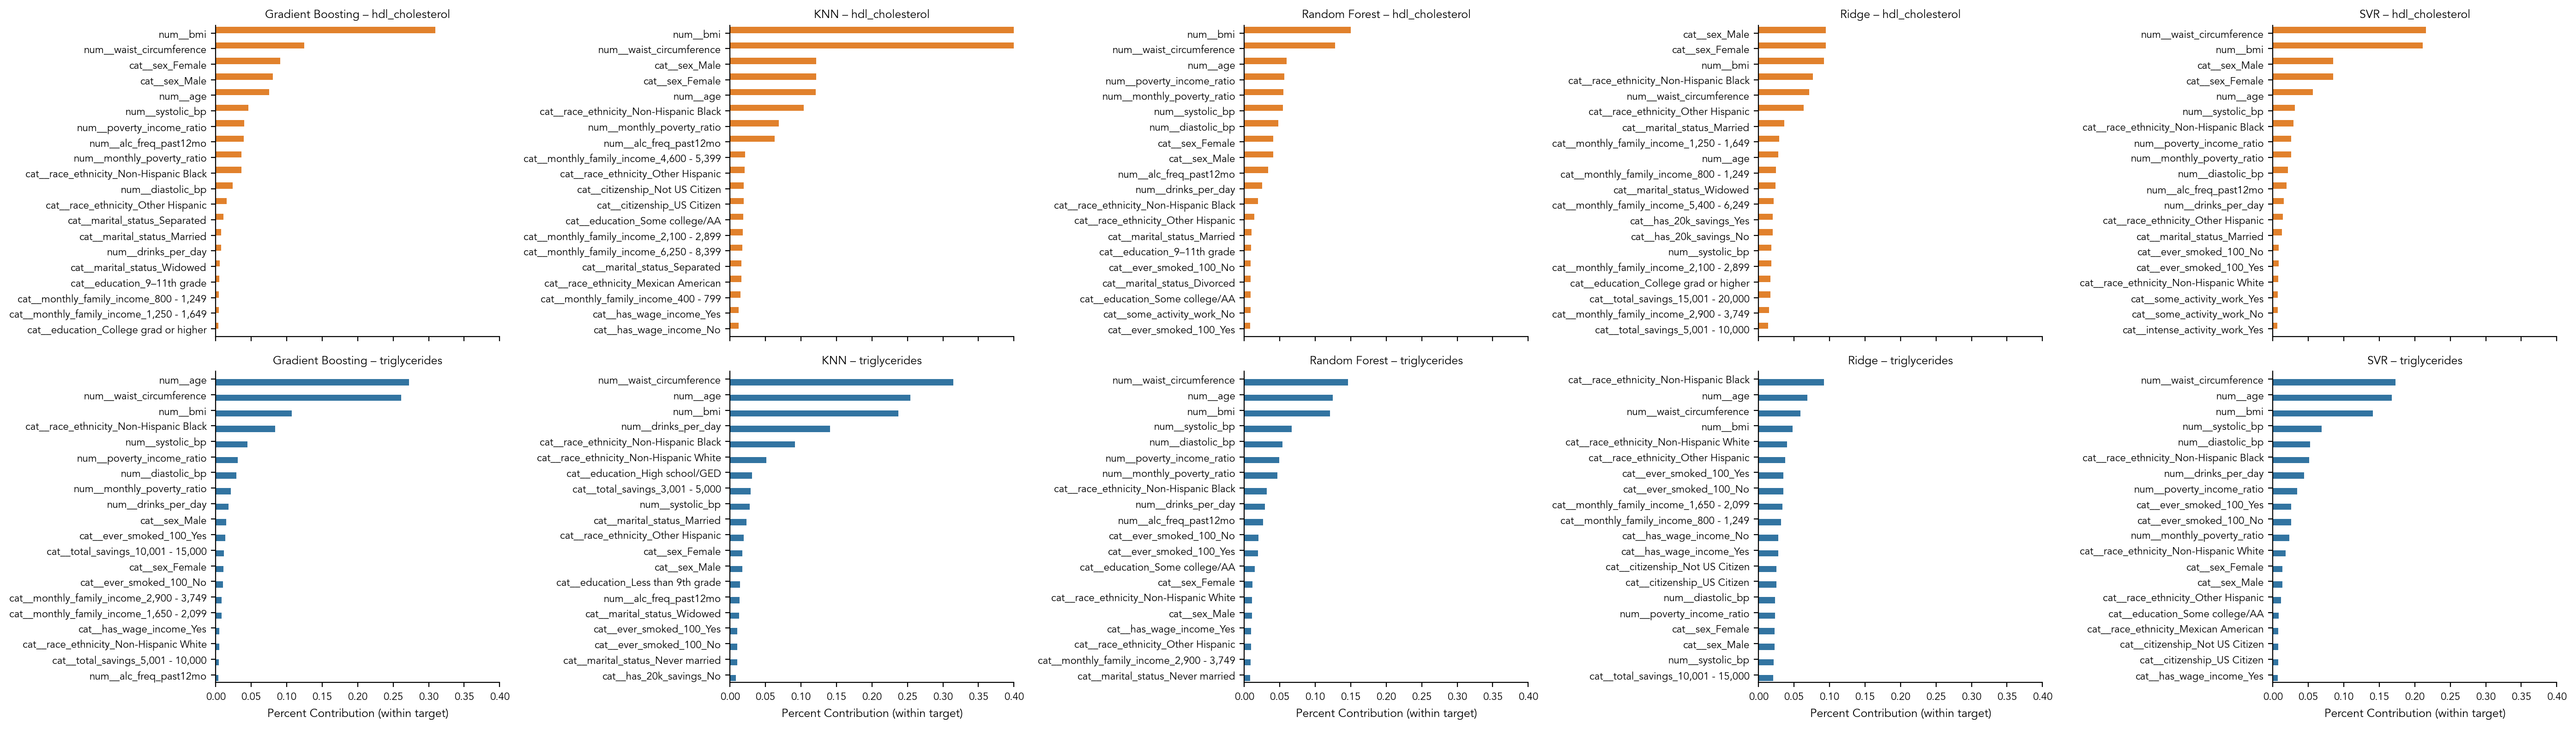

In [24]:
top_n = 20

top_features_df = (
    all_importances_df
    .groupby(["Model", "Target"], group_keys=False)
    .apply(lambda df: df.nlargest(top_n, "NormWithinTarget"))
)

g = sns.catplot(
    data=top_features_df,
    kind="bar",
    x="NormWithinTarget", y="Feature",
    hue="Target",
    col="Model", row="Target",
    palette=target_colors,
    sharex=True, sharey=False,
    height=4, aspect=1.4
)

g.set_titles("{col_name} – {row_name}")
g.set_axis_labels("Percent Contribution (within target)", "")
if g._legend:
    g._legend.set_title("")
for ax in g.axes.flat:
    ax.set_xlim(0, .4)
plt.tight_layout()
plt.show()


### 🔍 Feature Importance Summary

The plots above display the **percent contribution** of each feature to model predictions for **HDL Cholesterol** and **Triglycerides**, computed separately for each model. The values shown are normalized such that **the contributions across all features for each target-model pair sum to 1**.

---

#### 🧠 Common Top Predictors Across Models

- **BMI** and **Waist Circumference** consistently contribute a large share of the predictive power for both targets.
- **Age** is a dominant contributor for **Triglycerides**, especially in tree-based and distance-based models.
- **Systolic and Diastolic Blood Pressure** are moderately informative, especially for Gradient Boosting and Random Forest.

---

#### 🧬 HDL Cholesterol Insights

- **Sex (Male/Female)** ranks highly across most models, particularly Ridge and Random Forest.
- **Race/Ethnicity**, particularly *Non-Hispanic Black* and *Other Hispanic*, also contribute but vary across models.
- **Lifestyle variables** like alcohol and smoking are generally lower in importance but show up consistently.

---

#### 🩸 Triglyceride Insights

- **Age**, **Waist Circumference**, and **Race/Ethnicity** are the most impactful features across all models.
- **Smoking status** and **alcohol consumption** contribute meaningfully to triglyceride prediction.
- Economic features like **poverty-income ratio** and **family income brackets** also appear among the top contributors.

---

#### ⚙️ Modeling Observations

- **Tree-based models** (Random Forest, Gradient Boosting) spread importance across more features, reflecting their ability to capture complex interactions.
- **Linear models** (Ridge) and **kernel methods** (SVR) often assign more weight to a smaller number of dominant predictors.
- **KNN** heavily depends on a handful of distance-defining features.

---

#### ✅ Takeaways

- Feature contributions align with clinical and physiological expectations (e.g., BMI, age, waist size), suggesting a reasonable degree of model trustworthiness.
- Normalized percent contributions help identify which features are **truly driving the model**, regardless of absolute scale.
- You may consider retaining only the top ~10 features per target for a lighter model with minimal performance tradeoff—especially useful for interpretation, portability, or real-world deployment.
